In [2]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RNN,  Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
## Plotly
#import plotly.offline as py
#import plotly.graph_objs as go
#py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv("xxxxxxxx")
import re
def clean_text(text):
    
    ## Remove puncuation
    #text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text


In [4]:
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinavkhare/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df['TWEET_TEXT'] = df['TWEET_TEXT'].map(lambda x: clean_text(x))

In [6]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)

In [23]:
tokenizer

In [7]:
tokenizer.fit_on_texts(df['TWEET_TEXT'])


In [8]:
sequences = tokenizer.texts_to_sequences(df['TWEET_TEXT'])

In [9]:
data = pad_sequences(sequences, maxlen=50)
labels = df['label_ps']

In [40]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:


early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_46 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 75s 31ms/step - loss: 0.6086 - acc: 0.6904 - val_loss: nan - val_acc: 0.5663
Epoch 2/10
2442/2442 [==============================] - 65s 27ms/step - loss: 0.4185 - acc: 0.8120 - val_loss: nan - val_acc: 0.7279
Epoch 3/10
2442/2442 [==============================] - 72s 29ms/step - loss: 0.24

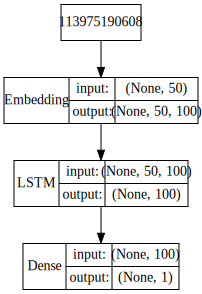

In [111]:
## LSTM
model_LSTM  = Sequential()
model_LSTM.add(Embedding(20000, 100, input_length=50))

model_LSTM.add(LSTM(100))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["acc" ] )
model_LSTM.summary()
# Fitting the data 
model_LSTM.fit(data, np.array(labels), validation_split=0.4, epochs=10, callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/3
2442/2442 [==============================] - 73s 30ms/step - loss: 0.6130 - f1: 0.8125 - val_loss: nan - val_f1: nan
Epoch 2/3
2442/2442 [==============================] - 69s 28ms/step - loss: 0.4617 - f1: 0.8611 - val_loss: nan - val_f1: nan
Epoch 3/3
2442/2442 [==============================] - 68s 28ms/step - loss: 0.2850 - f1: 0.92

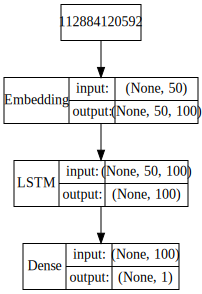

In [63]:
## LSTM 2 (dropout=0.2, recurrent_dropout=0.2)
model_LSTM2  = Sequential()
model_LSTM2.add(Embedding(20000, 100, input_length=50))
model_LSTM2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_LSTM2.add(Dense(1, activation='sigmoid'))
model_LSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM2.summary()
# Fitting the data 
model_LSTM2.fit(data, np.array(labels), validation_split=0.4, epochs=3)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM2, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_47 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 51        
Total params: 2,030,251
Trainable params: 2,030,251
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 46s 19ms/step - loss: 0.6084 - acc: 0.6867 - val_loss: nan - val_acc: 0.5608
Epoch 2/10
2442/2442 [==============================] - 39s 16ms/step - loss: 0.4411 - acc: 0.7903 - val_loss: nan - val_acc: 0.7396
Epoch 3/10
2442/2442 [==============================] - 37s 15ms/step - loss: 0.25

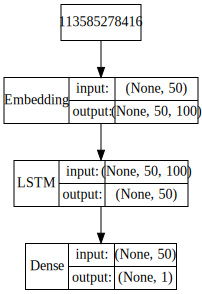

In [112]:
## LSTM 3 (units = 50)
model_LSTM3 = Sequential()
model_LSTM3.add(Embedding(20000, 100, input_length=50))
model_LSTM3.add(LSTM(50))
model_LSTM3.add(Dense(1, activation='sigmoid'))
model_LSTM3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM3.summary()
# Fitting the data 
model_LSTM3.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM3, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_49 (LSTM)               (None, 25)                12600     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 26        
Total params: 2,012,626
Trainable params: 2,012,626
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 32s 13ms/step - loss: 0.6155 - acc: 0.6867 - val_loss: nan - val_acc: 0.5553
Epoch 2/10
2442/2442 [==============================] - 22s 9ms/step - loss: 0.4703 - acc: 0.7662 - val_loss: nan - val_acc: 0.7125
Epoch 3/10
2442/2442 [==============================] - 23s 10ms/step - loss: 0.294

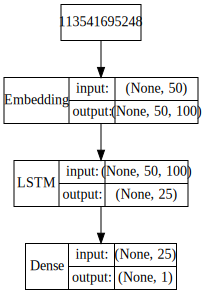

In [114]:
## LSTM 4 (units = 25)
model_LSTM4  = Sequential()
model_LSTM4.add(Embedding(20000, 100, input_length=50))
model_LSTM4.add(LSTM(25))
model_LSTM4.add(Dense(1, activation='sigmoid'))
model_LSTM4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM4.summary()
# Fitting the data 
model_LSTM4.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM4, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_50 (LSTM)               (None, 5)                 2120      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 6         
Total params: 2,002,126
Trainable params: 2,002,126
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 30s 12ms/step - loss: 0.6365 - acc: 0.6830 - val_loss: nan - val_acc: 0.5547
Epoch 2/10
2442/2442 [==============================] - 17s 7ms/step - loss: 0.5383 - acc: 0.7174 - val_loss: nan - val_acc: 0.6001
Epoch 3/10
2442/2442 [==============================] - 16s 7ms/step - loss: 0.4055

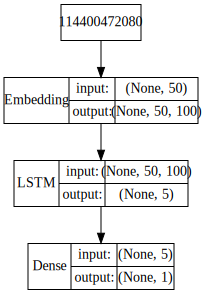

In [115]:
## LSTM 5 (units = 5)
model_LSTM5  = Sequential()
model_LSTM5.add(Embedding(20000, 100, input_length=50))
model_LSTM5.add(LSTM(5))
model_LSTM5.add(Dense(1, activation='sigmoid'))
model_LSTM5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM5.summary()
# Fitting the data 
model_LSTM5.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM5, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_51 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 89s 36ms/step - loss: 0.5996 - acc: 0.6962 - val_loss: nan - val_acc: 0.6149
Epoch 2/10
2442/2442 [==============================] - 87s 36ms/step - loss: 0.4190 - acc: 0.8280 - val_loss: nan - val_acc: 0.7217
Epoch 3/10
2442/2442 [==============================] - 78s 32ms/step - loss: 0.24

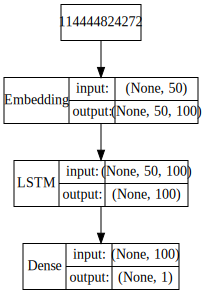

In [116]:
## LSTM 6 (dropout = 0.1)
model_LSTM6  = Sequential()
model_LSTM6.add(Embedding(20000, 100, input_length=50))
model_LSTM6.add(LSTM(100, dropout =0.1 ))
model_LSTM6.add(Dense(1, activation='sigmoid'))
model_LSTM6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM6.summary()
# Fitting the data 
model_LSTM6.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM6, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_59 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_52 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 102s 42ms/step - loss: 0.6043 - acc: 0.6888 - val_loss: nan - val_acc: 0.5725
Epoch 2/10
2442/2442 [==============================] - 92s 38ms/step - loss: 0.4248 - acc: 0.8133 - val_loss: nan - val_acc: 0.7346
Epoch 3/10
2442/2442 [==============================] - 93s 38ms/step - loss: 0.2

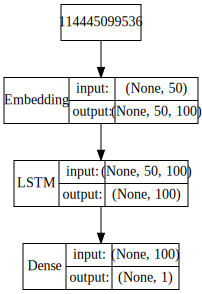

In [117]:
## LSTM 7 (dropout = 0.2)
model_LSTM7  = Sequential()
model_LSTM7.add(Embedding(20000, 100, input_length=50))
model_LSTM7.add(LSTM(100, dropout =0.2 ))
model_LSTM7.add(Dense(1, activation='sigmoid'))
model_LSTM7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM7.summary()
# Fitting the data 
model_LSTM7.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM7, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_65 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_58 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 98s 40ms/step - loss: 0.6093 - acc: 0.6896 - val_loss: nan - val_acc: 0.5541
Epoch 2/10
2442/2442 [==============================] - 83s 34ms/step - loss: 0.4792 - acc: 0.7654 - val_loss: nan - val_acc: 0.7082
Epoch 3/10
2442/2442 [==============================] - 86s 35ms/step - loss: 0.32

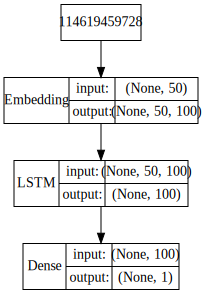

In [124]:
## LSTM 8(dropout = 0.5)
model_LSTM8  = Sequential()
model_LSTM8.add(Embedding(20000, 100, input_length=50))
model_LSTM8.add(LSTM(100, dropout =0.5 ))
model_LSTM8.add(Dense(1, activation='sigmoid'))
model_LSTM8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_LSTM8.summary()
# Fitting the data 
model_LSTM8.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM8, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_59 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 113s 46ms/step - loss: 0.5835 - acc: 0.7158 - val_loss: nan - val_acc: 0.6136
Epoch 2/10
2442/2442 [==============================] - 88s 36ms/step - loss: 0.2815 - acc: 0.8898 - val_loss: nan - val_acc: 0.6695
Epoch 3/10
2442/2442 [==============================] - 85s 35ms/step - loss: 0.1

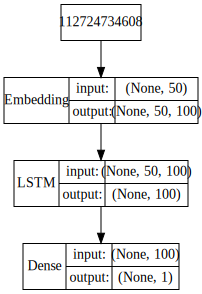

In [125]:
## LSTM 9(lr = 0.01)
model_LSTM9  = Sequential()
model_LSTM9.add(Embedding(20000, 100, input_length=50))
model_LSTM9.add(LSTM(100))
model_LSTM9.add(Dense(1, activation='sigmoid'))
adam2 = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_LSTM9.compile(loss='binary_crossentropy', optimizer=adam2, metrics=['acc'])
model_LSTM9.summary()
# Fitting the data 
model_LSTM9.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM9, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_56 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 115s 47ms/step - loss: 0.6137 - acc: 0.6888 - val_loss: nan - val_acc: 0.5706
Epoch 2/10
2442/2442 [==============================] - 92s 38ms/step - loss: 0.4414 - acc: 0.7936 - val_loss: nan - val_acc: 0.7131
Epoch 3/10
2442/2442 [==============================] - 94s 38ms/step - loss: 0.2

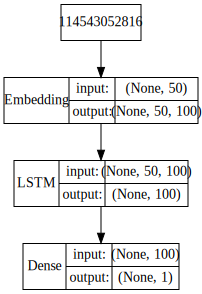

In [122]:
## LSTM 10(lr = 0.001)
model_LSTM10  = Sequential()
model_LSTM10.add(Embedding(20000, 100, input_length=50))
model_LSTM10.add(LSTM(100))
model_LSTM10.add(Dense(1, activation='sigmoid'))
adam1 = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_LSTM10.compile(loss='binary_crossentropy', optimizer=adam1, metrics=['acc'])
model_LSTM10.summary()
# Fitting the data 
model_LSTM10.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM10, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_67 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_60 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 107s 44ms/step - loss: 0.7083 - acc: 0.6360 - val_loss: nan - val_acc: 0.5510
Epoch 2/10
2442/2442 [==============================] - 86s 35ms/step - loss: 0.6563 - acc: 0.6605 - val_loss: nan - val_acc: 0.5528
Epoch 3/10
2442/2442 [==============================] - 83s 34ms/step - loss: 0.6

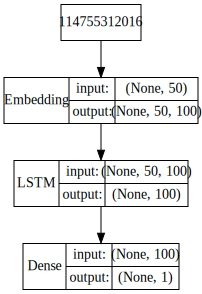

In [126]:
## LSTM 11(lr = 0.1)
model_LSTM11  = Sequential()
model_LSTM11.add(Embedding(20000, 100, input_length=50))
model_LSTM11.add(LSTM(100))
model_LSTM11.add(Dense(1, activation='sigmoid'))
adam3 = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_LSTM11.compile(loss='binary_crossentropy', optimizer=adam3, metrics=['acc'])
model_LSTM11.summary()
# Fitting the data 
model_LSTM11.fit(data, np.array(labels), validation_split=0.4, epochs=10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model_LSTM11, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [62]:
word_embds = model.layers[0].get_weights()[0]


In [76]:
words = []
for word, i in tokenizer.word_index.items():
    words.append(word)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 46, 64)            32064     
_________________________________________________________________
flatten_4 (Flatten)          (None, 2944)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 2945      
Total params: 2,035,009
Trainable params: 2,035,009
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 46s 19ms/step - loss: 0.6203

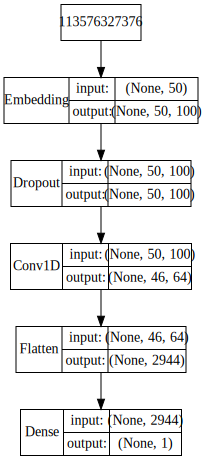

In [127]:
# Training a CNN 
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(Flatten())
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['acc'])
    return model_conv
model_conv = create_conv_model()
model_conv.summary()
model_conv.fit(data, np.array(labels), validation_split=0.4, epochs = 10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_conv, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 46, 64)            32064     
_________________________________________________________________
lstm_61 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 101       
Total params: 2,098,165
Trainable params: 2,098,165
Non-trainable params: 0
_________________________________________________________________
Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 116s 47ms/step - loss: 0.603

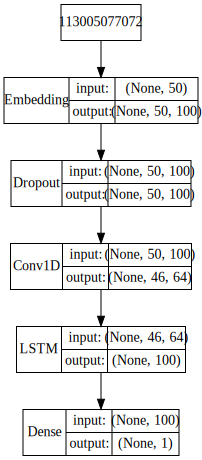

In [128]:
# CNN + LSTM
def create_conv_LSTM2_model():
    model_conv_LSTM2 = Sequential()
    model_conv_LSTM2.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv_LSTM2.add(Dropout(0.2))
    model_conv_LSTM2.add(Conv1D(64, 5, activation='relu'))
    model_conv_LSTM2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model_conv_LSTM2.add(Dense(1, activation='sigmoid'))
    model_conv_LSTM2.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['acc'])
    return model_conv_LSTM2
model_conv_LSTM2 = create_conv_LSTM2_model()
model_conv_LSTM2.summary()
model_conv_LSTM2.fit(data, np.array(labels), validation_split=0.4, epochs = 10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_conv_LSTM2, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_70 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 704)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 705       
Total params: 2,032,769
Trainable params: 2,032,769
Non-trainable params: 0
_________________________________________________________________


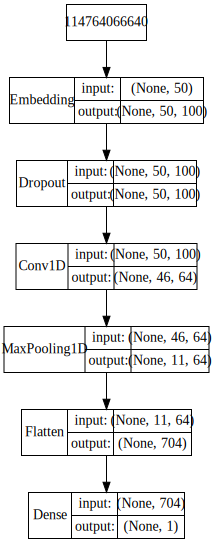

In [129]:
# CNN (with maxpooling)
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(Flatten())
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['acc'])
    return model_conv
model_conv = create_conv_model()
model_conv.summary()
model_conv.fit(data, np.array(labels), validation_split=0.4, epochs = 10,callbacks=[early_stopper])
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_conv, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))



In [130]:
# CNN + LSTM (with maxpooling)
def create_conv__LSTM_model():
    model_conv_LSTM = Sequential()
    model_conv_LSTM.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv_LSTM.add(Dropout(0.2))
    model_conv_LSTM.add(Conv1D(64, 5, activation='relu'))
    model_conv_LSTM.add(MaxPooling1D(pool_size=4))
    model_conv_LSTM.add(LSTM(100))
    model_conv_LSTM.add(Dense(1, activation='sigmoid'))
    model_conv_LSTM.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['acc'])
    return model_conv_LSTM
model_conv_LSTM = create_conv__LSTM_model()
SVG(model_to_dot(model_conv_LSTM, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))
model_conv_LSTM.summary()
model_conv_LSTM.fit(data, np.array(labels), validation_split=0.4, epochs = 10,callbacks=[early_stopper])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_71 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 101       
Total params: 2,098,165
Trainable params: 2,098,165
Non-trainable params: 0
_________________________________________________________________


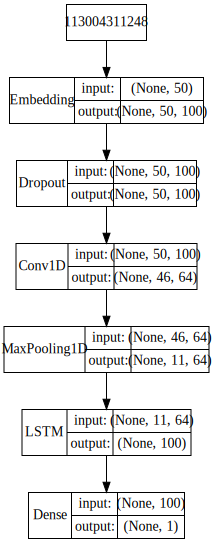

In [131]:
SVG(model_to_dot(model_conv_LSTM, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [132]:
conv_embds = model_conv.layers[0].get_weights()[0]

In [133]:
# Get embeddings from Glove

embeddings_index = dict()
f = open('/Users/abhinavkhare/Documents/Deep_Learning/project 2/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [134]:
#Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [135]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
## Fit train data
model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 10,callbacks=[early_stopper])

Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 99s 41ms/step - loss: 0.5905 - acc: 0.7019 - val_loss: nan - val_acc: 0.6615
Epoch 2/10
2442/2442 [==============================] - 71s 29ms/step - loss: 0.5223 - acc: 0.7473 - val_loss: nan - val_acc: 0.6591
Epoch 3/10
2442/2442 [==============================] - 66s 27ms/step - loss: 0.4960 - acc: 0.7580 - val_loss: nan - val_acc: 0.6726
Epoch 4/10
2442/2442 [==============================] - 65s 27ms/step - loss: 0.4723 - acc: 0.7764 - val_loss: nan - val_acc: 0.6929
Epoch 5/10
2442/2442 [==============================] - 65s 27ms/step - loss: 0.4494 - acc: 0.7924 - val_loss: nan - val_acc: 0.7009
Epoch 6/10
2442/2442 [==============================] - 67s 27ms/step - loss: 0.4211 - acc: 0.8088 - val_loss: nan - val_acc: 0.6572
Epoch 7/10
2442/2442 [==============================] - 65s 27ms/step - loss: 0.3968 - acc: 0.8251 - val_loss: nan - val_acc: 0.6990
Epoch 8/10
2442/2442 

In [136]:
## Get embeddings from CRISIS_NLP
embeddings_index2 = dict()
f = open('/Users/abhinavkhare/Documents/Deep_Learning/project 2/crisis_embeddings.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index2[word] = coefs
f.close()

In [137]:
#Create a weight matrix for words in training docs
embedding_matrix2 = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector2 = embeddings_index2.get(word)
        if embedding_vector2 is not None:
            embedding_matrix2[index] = embedding_vector2

In [139]:
model_C = Sequential()
model_C.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_C.add(LSTM(100))
model_C.add(Dense(1, activation='sigmoid'))
model_C.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
## Fit train data
model_C.fit(data, np.array(labels), validation_split=0.4, epochs = 10,callbacks=[early_stopper])

Train on 2442 samples, validate on 1628 samples
Epoch 1/10
2442/2442 [==============================] - 84s 34ms/step - loss: 0.5822 - acc: 0.7125 - val_loss: nan - val_acc: 0.6843
Epoch 2/10
2442/2442 [==============================] - 72s 30ms/step - loss: 0.5215 - acc: 0.7424 - val_loss: nan - val_acc: 0.6511
Epoch 3/10
2442/2442 [==============================] - 71s 29ms/step - loss: 0.4876 - acc: 0.7711 - val_loss: nan - val_acc: 0.6677
Epoch 4/10
2442/2442 [==============================] - 68s 28ms/step - loss: 0.4645 - acc: 0.7817 - val_loss: nan - val_acc: 0.6916
Epoch 5/10
2442/2442 [==============================] - 70s 29ms/step - loss: 0.4331 - acc: 0.8055 - val_loss: nan - val_acc: 0.6738
Epoch 6/10
2442/2442 [==============================] - 69s 28ms/step - loss: 0.4140 - acc: 0.8063 - val_loss: nan - val_acc: 0.7052
Epoch 7/10
2442/2442 [==============================] - 69s 28ms/step - loss: 0.4050 - acc: 0.8268 - val_loss: nan - val_acc: 0.6837
Epoch 8/10
2442/2442 